In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# WSN model and mean field approximation

In [2]:
n = 5 # Dimension of the model

alpha=0.09
beta=0.9
lamb = 0.09
gamma=0.01
nu=0.01


def computeK(m):
    K = np.zeros(shape=(n,n))
    K[0,1] = beta*m[2];               K[0,0] = 1-K[0,1]
    K[1,0] = alpha;                   K[1,1] = 1-K[1,0]
    K[2,3] = gamma; K[2,4]=beta*m[0]; K[2,2] = 1-K[2,3]-K[2,4]
    K[3,2] = nu;                      K[3,3] = 1-K[3,2]
    K[4,2] = lamb;                    K[4,4] = 1-K[4,2]
    for i in range(5):
        for j in range(5):
            if K[i,j] < 0 or K[i,j] > 1: 
                print('rate error: K[',i,j,']=',K[i,j])
    return(K)

m0 = np.array([1/3.,0,0,0,2/3.])

def simulate(m0,T):
    m=m0
    M=np.zeros(shape=(T,n))
    for t in range(T):
        m = np.tensordot(m,computeK(m),1)
        M[t,:] = m
    return(M)

def h(m):
    return(min((m[2]+m[3])/(lamb*m[4]),100))

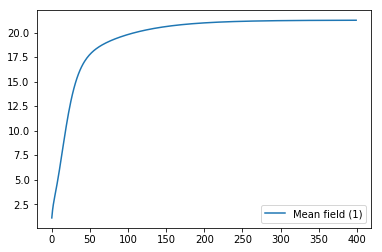

In [3]:
plt.plot([h(m) for m in simulate(m0,400)])
plt.legend(['Mean field (1)'])

# Refined Mean field

In [4]:
n=5
def computeA(m):
    return(np.array([
        [1-beta*m[2],            alpha,      -beta*m[0] , 0, 0], 
        [beta*m[2],              1-alpha,    beta*m[0],   0, 0],
        [-beta*m[2],             0,          1-gamma-beta*m[0],      nu, lamb], 
        [0,                      0,          gamma,                1-nu, 0],
        [beta*m[2],              0,          beta*m[0],            0,    1-lamb]]))
def computeB(m):
    B = np.zeros(shape=(n,n,n))
    B[0,0,2] = -beta
    B[0,2,0] = -beta
    B[2,0,2] = -beta
    B[2,2,0] = -beta
    B[1,0,2] = beta
    B[1,2,0] = beta
    B[4,0,2] = beta
    B[4,2,0] = beta
    return(B)
def computeGamma(m):
    G = np.zeros(shape=(n,n))
    K = computeK(m)
    for j in range(n):
        for k in range(n):
            if j==k: 
                G[j,k] = sum([m[i]*K[i,j]*(1-K[i,j]) for i in range(n)])
            else:
                G[j,k] = sum([m[i]*K[i,j]*(-K[i,k]) for i in range(n)])
    return(G)

def dH(m):
    return(np.array([0,0,1/(lamb*m[4]),1/(lamb*m[4]),-(m[2]+m[3])/(lamb*m[4]**2)]))
def ddH(m):
    return(np.array([
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,0,0,-1/(lamb*m[4]**2)],
    [0,0,0,0,-1/(lamb*m[4]**2)],
    [0,0,-1/(lamb*m[4]**2),-1/(lamb*m[4]**2),2*(m[2]+m[3])/(lamb*m[4]**3)]
    ]
    ))
def refinedMF(m0,T):
    m = m0
    v = np.zeros((n))
    w = np.zeros((n,n))
    
    M=[]
    V=[]
    W=[]
    
    for t in range(T):
        A = computeA(m)
        B = computeB(m)
        Gamma = computeGamma(m)
        
        M.append(m)
        
        v = np.dot(A,v) + np.tensordot(B,w,2)/2
        w = Gamma + np.dot(np.dot(A,w),np.transpose(A))
        m = np.tensordot(m,computeK(m),1)
        
        V.append(v)
        W.append(w)
        
    return(np.array(M),np.array(V),np.array(W))

M,V,W = refinedMF(m0,500)


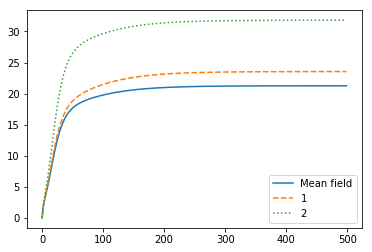

In [5]:
N=15
mf = np.array([h(m) for m in M])
rmf = mf+(np.array([np.tensordot(dH(m),v,1) for m,v in zip(M,V)])+ np.array([np.tensordot(ddH(m),w,2)/2 for m,w in zip(M,W)]))/N
plt.plot(mf)
plt.plot([h(m) for m in (M+V/N)],'--')
plt.plot(rmf,':')
plt.legend(['Mean field','1','2'])


# Comparison with simulations

In [6]:
import os 
import sys
import time

def simulate_MC(m0,T,N):
    m = np.array([int(N*m0[i]) for i in range(n)])
    M = []
    
    for t in range(T):
        M.append(m)
        K = computeK(m*1./N)
        newM = np.zeros(n)
        for i in range(n):
            newM += np.random.multinomial(m[i], K[i,:], size=1).reshape(n)
        m = newM
    return(np.array(M)*1./N)

def averageSimulation(m0,T,N,number_of_simulations,forceRedoSimulation=False):
    fileName = 'traj/simu_WSN_m{}_{}_{}_{}_{}_N{}_T{}.npz'.format(int(m0[0]*1000),
                                                           int(m0[1]*1000),
                                                           int(m0[2]*1000),
                                                           int(m0[3]*1000),
                                                            int(m0[4]*1000),
                                                           N,
                                                           T)
    if os.path.isfile(fileName) and not forceRedoSimulation :
        data = np.load(fileName)
        alreadyDoneSimu = data['nbSimu']
        M = data['M']
        hM = data['hM']
    else:
        alreadyDoneSimu = 0
        M = np.zeros(shape=(T,len(m0)))
        hM = np.zeros(shape=(T))
    if alreadyDoneSimu < number_of_simulations:
        for i in range(alreadyDoneSimu,number_of_simulations):
            sampleM = simulate_MC(m0,T,N)
            M += sampleM
            hM += np.array([h(m) for m in sampleM])
            print('\r{}/{}'.format(i,number_of_simulations),end='')
        np.savez(fileName,M=M,hM=hM,nbSimu=number_of_simulations)
    return(M/max(alreadyDoneSimu,number_of_simulations), hM/max(alreadyDoneSimu,number_of_simulations))

#m0 = np.array([1,0,0,0])
m0 = np.array([1/3,0.,0.,0.,2/3.])

for N in [15,150,1500]:
    for numberSimu in range(0,(10001 if N<=100 else 1001),200):
        # This code will generate 50000 simulation and saves the result each 5000 simulation (hence it can be interupted)
        Msimu,hMsimu = averageSimulation(m0,T=500,N=N,number_of_simulations=numberSimu)

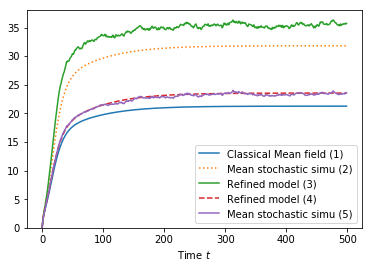

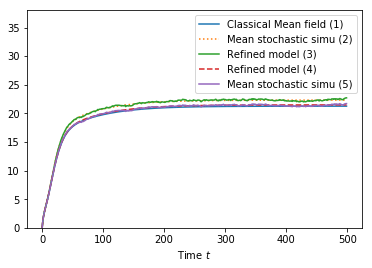

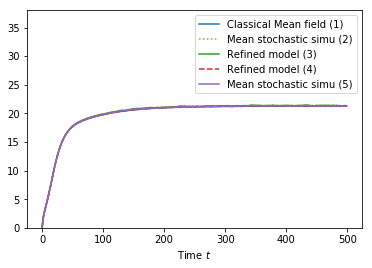

In [7]:
M,V,W = refinedMF(m0,500)

for N in [15,150,1500]:
    Msimu,hMsimu = averageSimulation(m0,T=500,N=N,number_of_simulations=numberSimu)
    mf = np.array([h(m) for m in M])
    rmf = mf+(np.array([np.tensordot(dH(m),v,1) for m,v in zip(M,V)])+ np.array([np.tensordot(ddH(m),w,2)/2 for m,w in zip(M,W)]))/N
    f=plt.figure()
    plt.plot(mf)
    plt.plot(rmf,':')
    plt.plot(hMsimu)
    plt.plot([h(m) for m in (M+V/N)],'--')
    plt.plot([h(m) for m in Msimu])
    plt.xlabel('Time $t$')
    plt.ylim([0,38])
    plt.legend(['Classical Mean field (1)','Mean stochastic simu (2)','Refined model (3)','Refined model (4)', 'Mean stochastic simu (5)'])
    f.savefig('WSNmodel_simu_N{}.pdf'.format(N),bbox_inches='tight')


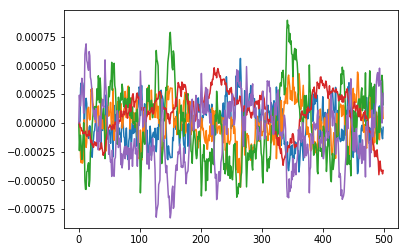

In [8]:
plt.plot(Msimu - (M+V/N))

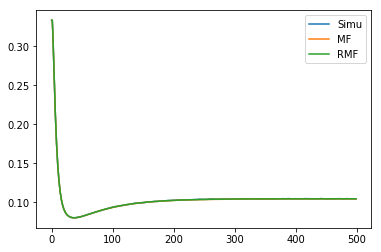

In [9]:
plt.plot(Msimu[:,0])
plt.plot(M[:,0])
plt.plot((M+V/N)[:,0])
plt.legend(['Simu','MF','RMF'])